In [143]:
import joblib, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [144]:
fold_data = joblib.load("models/fold_data_DF_fold_1.pkl")

x_train = fold_data["x_train"]
x_test  = fold_data["x_test"]
y_train = fold_data["y_train"]
y_test  = fold_data["y_test"]

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print("metadata:", fold_data["metadata"])

(1600, 10) (400, 10) (1600,) (400,)
metadata: Data split holdout 80/20; random_state=42


In [145]:
def eval_model(model, Xtr, ytr, Xte, yte, name="model"):
    model.fit(Xtr, ytr)
    ypred=model.predict(Xte)
    rmse = np.sqrt(mean_squared_error(yte, ypred))
    r2 = r2_score(yte, ypred)
    mae = mean_absolute_error(yte, ypred)
    return {"Name_Model": name, "RMSE": rmse, "R2": r2, "MAE": mae, "model": model}

In [146]:
d=x_train.shape[1]
d
ls0 = np.ones(d)

In [147]:
kernel_rbf = C(1.0, (1e-3, 1e3)) * RBF(length_scale=ls0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-10, 1e-2))
gpr_rbf = Pipeline([
    ("scaler", StandardScaler()),
    ("gp", GaussianProcessRegressor(
    kernel=kernel_rbf,
    normalize_y=True,
    n_restarts_optimizer=5,
    random_state=42
    ))
])

In [148]:
kernel_matern = C(1.0, (1e-3, 1e3)) * Matern(length_scale=ls0, length_scale_bounds=(1e-2, 1e2), nu=1.5) + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-10, 1e-2))
gpr_matern = Pipeline([
    ("scaler", StandardScaler()),
    ("gp", GaussianProcessRegressor(
    kernel=kernel_matern,
    normalize_y=True,
    n_restarts_optimizer=5,
    random_state=42
    ))
])

In [149]:
results= []
results.append(eval_model(gpr_rbf, x_train, y_train, x_test, y_test, name="GPR_RBF"))
results.append(eval_model(gpr_matern, x_train, y_train, x_test, y_test, name="GPR_Matern"))

/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing 

In [107]:
for r in results:
    print(r["Name_Model"], "RMSE:", r["RMSE"], "R2:", r["R2"], "MAE:", r["MAE"])

best= min(results, key=lambda x: x["RMSE"])
print(best)
print("BEST: " , best["Name_Model"])
print("Kernel otimizado: ", best["model"].named_steps["gp"].kernel_)


GPR_RBF RMSE: 602235.437161237 R2: 0.609855163325675 MAE: 353386.87561926997
GPR_Matern RMSE: 473389.37730307225 R2: 0.7589371613846477 MAE: 279251.4584056895
{'Name_Model': 'GPR_Matern', 'RMSE': 473389.37730307225, 'R2': 0.7589371613846477, 'MAE': 279251.4584056895, 'model': Pipeline(steps=[('scaler', StandardScaler()),
                ('gp',
                 GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], nu=1.5) + WhiteKernel(noise_level=1e-06),
                                          n_restarts_optimizer=5,
                                          normalize_y=True, random_state=42))])}
BEST:  GPR_Matern
Kernel otimizado:  10.4**2 * Matern(length_scale=[7.34, 100, 8.12, 38.2, 22.7, 8.97, 32.7, 6.1, 100, 13.3], nu=1.5) + WhiteKernel(noise_level=0.00157)


In [150]:
rbf_model = next(r["model"] for r in results if r["Name_Model"] == "GPR_RBF")
mat_model = next(r["model"] for r in results if r["Name_Model"] == "GPR_Matern")

y_pred_rbf = rbf_model.predict(x_test)
y_pred_mat = mat_model.predict(x_test)

err_rbf = y_test - y_pred_rbf
err_mat = y_test - y_pred_mat

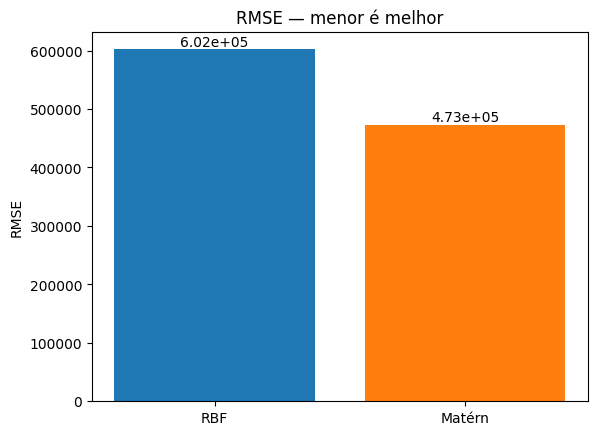

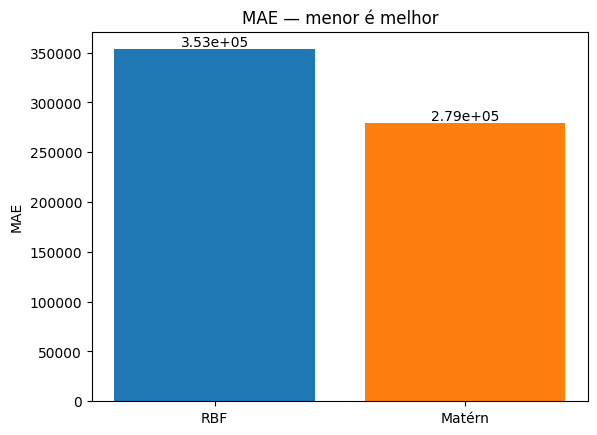

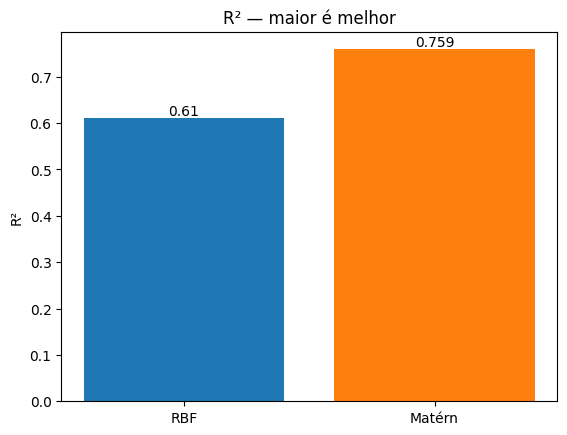

In [151]:
import matplotlib.pyplot as plt
import numpy as np

names = ["RBF", "Matérn"]
rmse  = [r["RMSE"] for r in results]
mae   = [r["MAE"]  for r in results]
r2    = [r["R2"]   for r in results]

def bar_with_labels(values, ylabel, title):
    plt.figure()
    bars = plt.bar(names, values, color=["tab:blue", "tab:orange"])
    plt.ylabel(ylabel)
    plt.title(title)
    for b, v in zip(bars, values):
        plt.text(b.get_x() + b.get_width()/2, b.get_height(), f"{v:.3g}",
                 ha="center", va="bottom")
    plt.show()

bar_with_labels(rmse, "RMSE", "RMSE — menor é melhor")
bar_with_labels(mae,  "MAE",  "MAE — menor é melhor")
bar_with_labels(r2,   "R²",   "R² — maior é melhor")

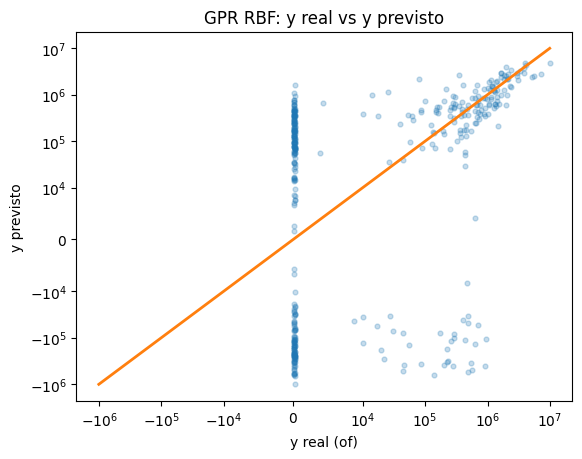

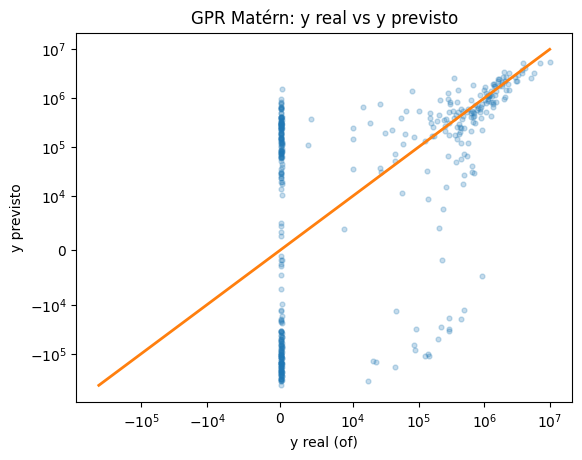

In [152]:
def plot_symlog(y_true, y_pred, title):
    ymin = float(min(y_true.min(), y_pred.min()))
    ymax = float(max(y_true.max(), y_pred.max()))

    plt.figure()
    plt.scatter(y_true, y_pred, s=12, alpha=0.25, color="tab:blue")
    plt.plot([ymin, ymax], [ymin, ymax], color="tab:orange", linewidth=2)
    plt.xscale("symlog", linthresh=1e4)
    plt.yscale("symlog", linthresh=1e4)

    plt.xlabel("y real (of)")
    plt.ylabel("y previsto")
    plt.title(title)
    plt.show()

plot_symlog(y_test, y_pred_rbf, "GPR RBF: y real vs y previsto")
plot_symlog(y_test, y_pred_mat, "GPR Matérn: y real vs y previsto")

In [153]:
print("min y_test:", y_test.min())
print("q1,q5,q50:", np.percentile(y_test, [1,5,50]))
print("quantos ~0:", np.mean(np.isclose(y_test, 0.0, atol=1e-9)))

min y_test: 66.58590564891881
q1,q5,q50: [ 70.05361308 100.46243464 226.69223168]
quantos ~0: 0.0



== RBF ==
min rel: 0.008296599279180153  max rel: 9648.995179341748
bin_width (aprox): 241.22467206856172
Primeiros 10 bins (intervalo -> contagem):
[0.0083, 241) -> 216
[241, 482) -> 31
[482, 724) -> 20
[724, 965) -> 16
[965, 1.21e+03) -> 22
[1.21e+03, 1.45e+03) -> 17
[1.45e+03, 1.69e+03) -> 13
[1.69e+03, 1.93e+03) -> 6
[1.93e+03, 2.17e+03) -> 9
[2.17e+03, 2.41e+03) -> 11
Últimos 5 bins:
[8.44e+03, 8.68e+03) -> 0
[8.68e+03, 8.93e+03) -> 0
[8.93e+03, 9.17e+03) -> 0
[9.17e+03, 9.41e+03) -> 0
[9.41e+03, 9.65e+03) -> 1


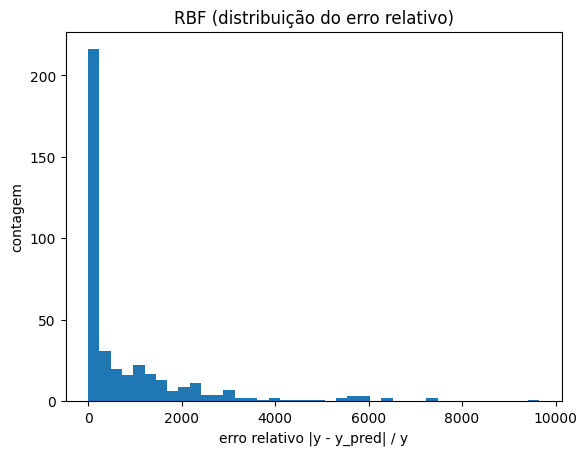


== Matérn ==
min rel: 0.005967802085958687  max rel: 12280.338081101658
bin_width (aprox): 307.0083028324893
Primeiros 10 bins (intervalo -> contagem):
[0.00597, 307) -> 229
[307, 614) -> 38
[614, 921) -> 25
[921, 1.23e+03) -> 28
[1.23e+03, 1.54e+03) -> 17
[1.54e+03, 1.84e+03) -> 16
[1.84e+03, 2.15e+03) -> 9
[2.15e+03, 2.46e+03) -> 4
[2.46e+03, 2.76e+03) -> 6
[2.76e+03, 3.07e+03) -> 6
Últimos 5 bins:
[1.07e+04, 1.11e+04) -> 0
[1.11e+04, 1.14e+04) -> 0
[1.14e+04, 1.17e+04) -> 0
[1.17e+04, 1.2e+04) -> 0
[1.2e+04, 1.23e+04) -> 1


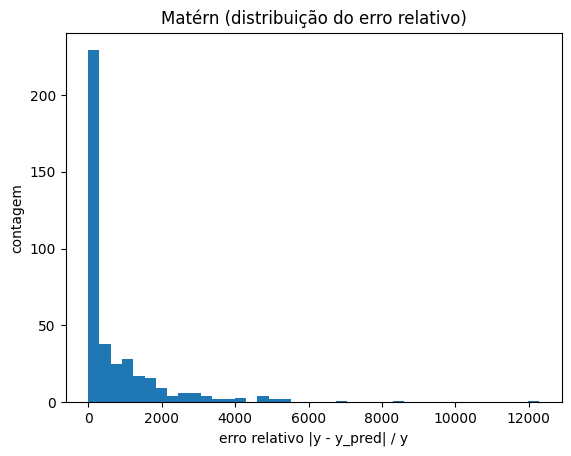

In [154]:
import numpy as np
import matplotlib.pyplot as plt

def plot_and_print_bins(y_true, y_pred, title, bins=40):
    rel = np.abs(y_true - y_pred) / y_true

    # calcula bins e contagens (mesmo que o hist usa)
    counts, edges = np.histogram(rel, bins=bins)

    print("\n==", title, "==")
    print("min rel:", rel.min(), " max rel:", rel.max())
    print("bin_width (aprox):", edges[1] - edges[0])
    print("Primeiros 10 bins (intervalo -> contagem):")
    for i in range(min(10, len(counts))):
        print(f"[{edges[i]:.3g}, {edges[i+1]:.3g}) -> {counts[i]}")
    print("Últimos 5 bins:")
    for i in range(len(counts)-5, len(counts)):
        print(f"[{edges[i]:.3g}, {edges[i+1]:.3g}) -> {counts[i]}")

    # plot
    plt.figure()
    plt.hist(rel, bins=bins)
    plt.xlabel("erro relativo |y - y_pred| / y")
    plt.ylabel("contagem")
    plt.title(title + " (distribuição do erro relativo)")
    plt.show()

plot_and_print_bins(y_test, y_pred_rbf, "RBF", bins=40)
plot_and_print_bins(y_test, y_pred_mat, "Matérn", bins=40)

In [155]:
def accuracy_rates(y_true, y_pred, name):
    rel = np.abs(y_true - y_pred) / y_true
    for t in [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 1000.0]:
        print(f"{name}: % com erro <= {int(t*100)}% = {100*np.mean(rel <= t):.1f}%")

accuracy_rates(y_test, y_pred_rbf, "RBF")
accuracy_rates(y_test, y_pred_mat, "Matérn")

RBF: % com erro <= 10% = 4.0%
RBF: % com erro <= 20% = 7.5%
RBF: % com erro <= 50% = 17.5%
RBF: % com erro <= 100% = 29.5%
RBF: % com erro <= 200% = 35.2%
RBF: % com erro <= 500% = 40.8%
RBF: % com erro <= 100000% = 71.8%
Matérn: % com erro <= 10% = 5.8%
Matérn: % com erro <= 20% = 10.0%
Matérn: % com erro <= 50% = 22.8%
Matérn: % com erro <= 100% = 33.2%
Matérn: % com erro <= 200% = 39.5%
Matérn: % com erro <= 500% = 41.5%
Matérn: % com erro <= 100000% = 74.2%


In [ ]:
# function to train and evaluate GPR model with given hyperparameters... 
def train_eval_gpr(nu, noise_ub, alpha, restarts):
    d = x_train.shape[1]
    kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=np.ones(d),
                                          length_scale_bounds=(1e-2, 1e2),
                                          nu=nu) \
             + WhiteKernel(noise_level=1e-6,
                           noise_level_bounds=(1e-10, noise_ub))
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("gp", GaussianProcessRegressor(
            kernel=kernel,
            normalize_y=True,
            alpha=alpha,
            n_restarts_optimizer=restarts,
            random_state=42
        ))
    ])
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mae  = mean_absolute_error(y_test, pred)
    r2   = r2_score(y_test, pred)
    return rmse, mae, r2, model

In [ ]:
# grid search over hyperparameters to find the best configuration (i tried with just 0, 3 restarts as well, and had similar results)
candidates = []
for nu in [1.5, 2.5]:
    for noise_ub in [1e-2, 1e-1]:
        for alpha in [1e-10, 1e-8, 1e-6]:
            for restarts in [0, 5, 10]: # try with [0, 3] restarts to speed
                rmse, mae, r2, model = train_eval_gpr(nu, noise_ub, alpha, restarts)
                candidates.append((rmse, mae, r2, nu, noise_ub, alpha, restarts, model))
                print(f"nu={nu} noise_ub={noise_ub} alpha={alpha} restarts={restarts} | RMSE={rmse:.3g} R2={r2:.3f}")


best = min(candidates, key=lambda t: t[0])
rmse, mae, r2, nu, noise_ub, alpha, restarts, best_model = best
print("\nBEST config:",
      f"nu={nu}, noise_ub={noise_ub}, alpha={alpha}, restarts={restarts}")
print("Kernel otimizado:", best_model.named_steps["gp"].kernel_)

/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


nu=1.5 noise_ub=0.01 alpha=1e-10 restarts=0 | RMSE=4.74e+05 R2=0.759


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


nu=1.5 noise_ub=0.01 alpha=1e-10 restarts=5 | RMSE=4.73e+05 R2=0.759


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


nu=1.5 noise_ub=0.01 alpha=1e-10 restarts=10 | RMSE=4.73e+05 R2=0.759


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


nu=1.5 noise_ub=0.01 alpha=1e-08 restarts=0 | RMSE=4.74e+05 R2=0.759


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


nu=1.5 noise_ub=0.01 alpha=1e-08 restarts=5 | RMSE=4.73e+05 R2=0.759


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


nu=1.5 noise_ub=0.01 alpha=1e-08 restarts=10 | RMSE=4.73e+05 R2=0.759


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


nu=1.5 noise_ub=0.01 alpha=1e-06 restarts=0 | RMSE=4.74e+05 R2=0.759


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


nu=1.5 noise_ub=0.01 alpha=1e-06 restarts=5 | RMSE=4.73e+05 R2=0.759


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


nu=1.5 noise_ub=0.01 alpha=1e-06 restarts=10 | RMSE=4.73e+05 R2=0.759


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


nu=1.5 noise_ub=0.1 alpha=1e-10 restarts=0 | RMSE=4.74e+05 R2=0.759


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


nu=1.5 noise_ub=0.1 alpha=1e-10 restarts=5 | RMSE=4.73e+05 R2=0.759


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


nu=1.5 noise_ub=0.1 alpha=1e-10 restarts=10 | RMSE=4.73e+05 R2=0.759


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


nu=1.5 noise_ub=0.1 alpha=1e-08 restarts=0 | RMSE=4.74e+05 R2=0.759


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


nu=1.5 noise_ub=0.1 alpha=1e-08 restarts=5 | RMSE=4.73e+05 R2=0.759


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


nu=1.5 noise_ub=0.1 alpha=1e-08 restarts=10 | RMSE=4.73e+05 R2=0.759


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


nu=1.5 noise_ub=0.1 alpha=1e-06 restarts=0 | RMSE=4.74e+05 R2=0.759


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


nu=1.5 noise_ub=0.1 alpha=1e-06 restarts=5 | RMSE=4.73e+05 R2=0.759


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


nu=1.5 noise_ub=0.1 alpha=1e-06 restarts=10 | RMSE=4.73e+05 R2=0.759


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


nu=2.5 noise_ub=0.01 alpha=1e-10 restarts=0 | RMSE=5.03e+05 R2=0.728


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing 

nu=2.5 noise_ub=0.01 alpha=1e-10 restarts=5 | RMSE=4.92e+05 R2=0.739


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing 

nu=2.5 noise_ub=0.01 alpha=1e-10 restarts=10 | RMSE=4.92e+05 R2=0.739


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


nu=2.5 noise_ub=0.01 alpha=1e-08 restarts=0 | RMSE=5.03e+05 R2=0.728


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing 

nu=2.5 noise_ub=0.01 alpha=1e-08 restarts=5 | RMSE=4.92e+05 R2=0.739


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing 

nu=2.5 noise_ub=0.01 alpha=1e-08 restarts=10 | RMSE=4.92e+05 R2=0.739


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


nu=2.5 noise_ub=0.01 alpha=1e-06 restarts=0 | RMSE=5.03e+05 R2=0.728


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing 

nu=2.5 noise_ub=0.01 alpha=1e-06 restarts=5 | RMSE=4.92e+05 R2=0.739


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing 

nu=2.5 noise_ub=0.01 alpha=1e-06 restarts=10 | RMSE=4.92e+05 R2=0.739


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


nu=2.5 noise_ub=0.1 alpha=1e-10 restarts=0 | RMSE=5.03e+05 R2=0.728


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


nu=2.5 noise_ub=0.1 alpha=1e-10 restarts=5 | RMSE=4.73e+05 R2=0.759


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


nu=2.5 noise_ub=0.1 alpha=1e-10 restarts=10 | RMSE=4.73e+05 R2=0.759


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


nu=2.5 noise_ub=0.1 alpha=1e-08 restarts=0 | RMSE=5.03e+05 R2=0.728


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


nu=2.5 noise_ub=0.1 alpha=1e-08 restarts=5 | RMSE=4.73e+05 R2=0.759


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


nu=2.5 noise_ub=0.1 alpha=1e-08 restarts=10 | RMSE=4.73e+05 R2=0.759


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


nu=2.5 noise_ub=0.1 alpha=1e-06 restarts=0 | RMSE=5.03e+05 R2=0.728


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


nu=2.5 noise_ub=0.1 alpha=1e-06 restarts=5 | RMSE=4.73e+05 R2=0.759
nu=2.5 noise_ub=0.1 alpha=1e-06 restarts=10 | RMSE=4.73e+05 R2=0.759

BEST config: nu=1.5, noise_ub=0.01, alpha=1e-10, restarts=5
Kernel otimizado: 10.4**2 * Matern(length_scale=[7.34, 100, 8.12, 38.2, 22.7, 8.97, 32.7, 6.1, 100, 13.3], nu=1.5) + WhiteKernel(noise_level=0.00157)


/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/lucasteixeira/Documents/Iniciacao_cientifica/fundaIA/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [88]:

df_res = pd.DataFrame(
    [{
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "nu": nu,
        "noise_ub": noise_ub,
        "alpha": alpha,
        "restarts": restarts,
    } for (rmse, mae, r2, nu, noise_ub, alpha, restarts, model) in candidates]
)

df_res

,rmse,mae,r2,nu,noise_ub,alpha,restarts
0,473750.926639,279723.405004,0.758569,1.5,0.01,1.000000e-10,0
1,473389.377303,279251.458406,0.758937,1.5,0.01,1.000000e-10,5
2,473389.377303,279251.458406,0.758937,1.5,0.01,1.000000e-10,10
3,473754.477490,279724.280577,0.758565,1.5,0.01,1.000000e-08,0
4,473390.015468,279252.880190,0.758937,1.5,0.01,1.000000e-08,5
5,473390.015468,279252.880190,0.758937,1.5,0.01,1.000000e-08,10
6,473752.325751,279723.432005,0.758567,1.5,0.01,1.000000e-06,0
7,473389.794199,279252.179454,0.758937,1.5,0.01,1.000000e-06,5
8,473389.794199,279252.179454,0.758937,1.5,0.01,1.000000e-06,10
9,473750.926639,279723.405004,0.758569,1.5,0.10,1.000000e-10,0


In [95]:
#gap is the difference to the best found

best_rmse = df_res["rmse"].min()        #best RMSE
best_mae  = df_res["mae"].min()     #best MAE
best_r2   = df_res["r2"].max()      #best R2

df_res = df_res.copy()
df_res["rmse_gap"] = df_res["rmse"] - best_rmse #gap to best RMSE
df_res["mae_gap"]  = df_res["mae"]  - best_mae #gap to best MAE
df_res["r2_gap"]   = best_r2 - df_res["r2"]     #gap to best R2


df_res["rmse_gap_%"] = 100.0 * (df_res["rmse"] / best_rmse - 1.0) #gap in percentage to best RMSE
df_res["mae_gap_%"]  = 100.0 * (df_res["mae"]  / best_mae  - 1.0)   #gap in percentage to best MAE
df_res

,rmse,mae,r2,nu,noise_ub,alpha,restarts,rmse_gap,mae_gap,r2_gap,rmse_gap_%,mae_gap_%
0,473750.926639,279723.405004,0.758569,1.5,0.01,1.000000e-10,0,361.549336,471.946598,3.683623e-04,0.076375,0.169004
1,473389.377303,279251.458406,0.758937,1.5,0.01,1.000000e-10,5,0.000000,0.000000,0.000000e+00,0.000000,0.000000
2,473389.377303,279251.458406,0.758937,1.5,0.01,1.000000e-10,10,0.000000,0.000000,0.000000e+00,0.000000,0.000000
3,473754.477490,279724.280577,0.758565,1.5,0.01,1.000000e-08,0,365.100187,472.822172,3.719814e-04,0.077125,0.169318
4,473390.015468,279252.880190,0.758937,1.5,0.01,1.000000e-08,5,0.638165,1.421785,6.499426e-07,0.000135,0.000509
5,473390.015468,279252.880190,0.758937,1.5,0.01,1.000000e-08,10,0.638165,1.421785,6.499426e-07,0.000135,0.000509
6,473752.325751,279723.432005,0.758567,1.5,0.01,1.000000e-06,0,362.948448,471.973600,3.697883e-04,0.076670,0.169014
7,473389.794199,279252.179454,0.758937,1.5,0.01,1.000000e-06,5,0.416896,0.721048,4.245896e-07,0.000088,0.000258
8,473389.794199,279252.179454,0.758937,1.5,0.01,1.000000e-06,10,0.416896,0.721048,4.245896e-07,0.000088,0.000258
9,473750.926639,279723.405004,0.758569,1.5,0.10,1.000000e-10,0,361.549336,471.946598,3.683623e-04,0.076375,0.169004


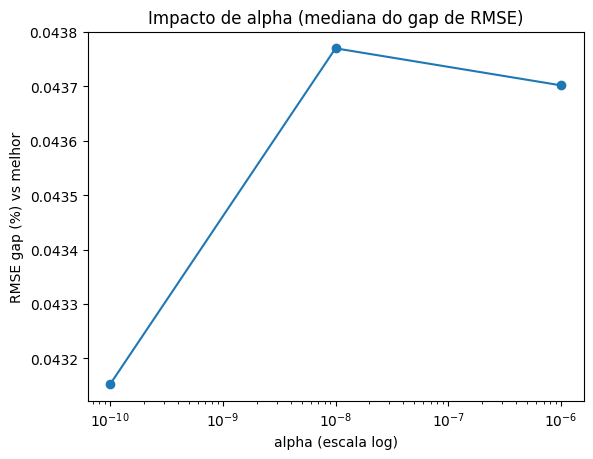

In [97]:
g = df_res.groupby("alpha")["rmse_gap_%"].agg(["mean","median","min","max"]).reset_index()
g = g.sort_values("alpha")

plt.figure()
plt.plot(g["alpha"], g["median"].to_numpy(), marker="o")
plt.xscale("log")
plt.xlabel("alpha (escala log)")
plt.ylabel("RMSE gap (%) vs melhor")
plt.title("Impacto de alpha (mediana do gap de RMSE)")
plt.show()

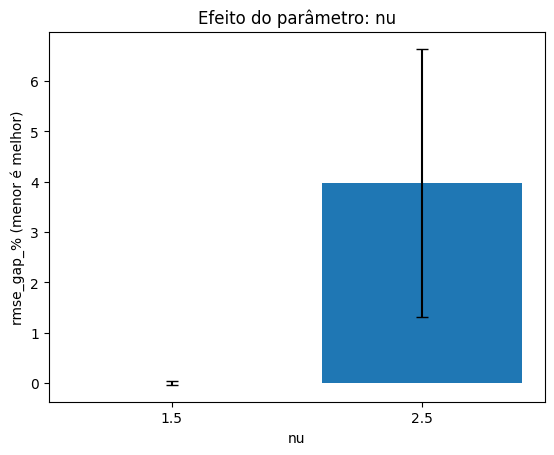

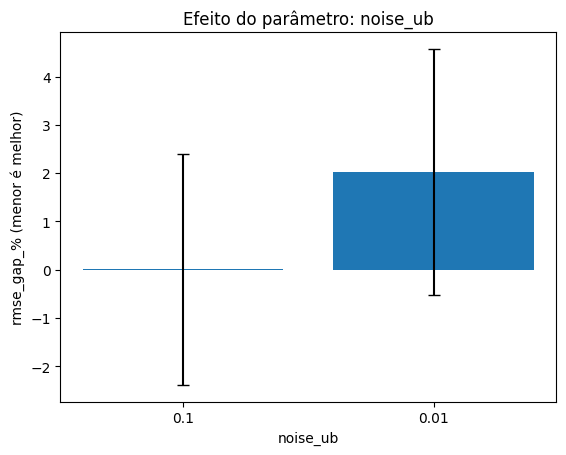

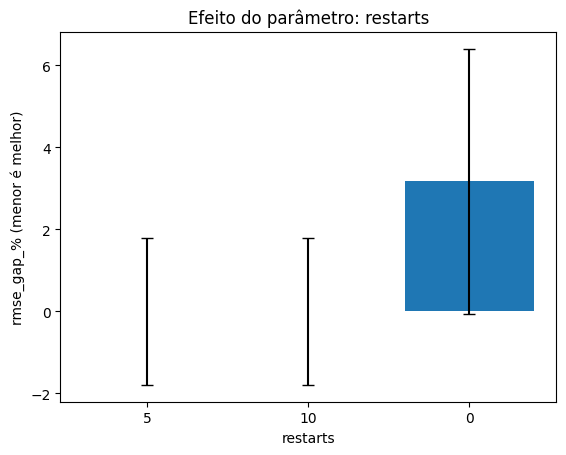

In [91]:
def plot_param_effect(df, param, metric="rmse_gap_%"):
    g = df.groupby(param)[metric].agg(["mean","std","median","count"]).reset_index()
    # ordena pela mediana (mais robusto que mean)
    g = g.sort_values("median")

    plt.figure()
    x = np.arange(len(g))
    plt.bar(x, g["median"].to_numpy(), yerr=g["std"].to_numpy(), capsize=4)
    plt.xticks(x, [str(v) for v in g[param]])
    plt.xlabel(param)
    plt.ylabel(f"{metric} (menor é melhor)")
    plt.title(f"Efeito do parâmetro: {param}")
    plt.show()

plot_param_effect(df_res, "nu")
plot_param_effect(df_res, "noise_ub")
plot_param_effect(df_res, "restarts")

In [92]:
topk = 10
best_configs = df_res.sort_values("rmse").head(topk)

print(best_configs[["rmse","r2","nu","noise_ub","alpha","restarts"]])

# frequência dos parâmetros no top-k
for col in ["nu","noise_ub","alpha","restarts"]:
    print("\nTop-k frequency:", col)
    print(best_configs[col].value_counts())

             rmse        r2   nu  noise_ub         alpha  restarts
1   473389.377303  0.758937  1.5      0.01  1.000000e-10         5
2   473389.377303  0.758937  1.5      0.01  1.000000e-10        10
11  473389.621117  0.758937  1.5      0.10  1.000000e-10        10
10  473389.621117  0.758937  1.5      0.10  1.000000e-10         5
17  473389.625029  0.758937  1.5      0.10  1.000000e-06        10
16  473389.625029  0.758937  1.5      0.10  1.000000e-06         5
7   473389.794199  0.758937  1.5      0.01  1.000000e-06         5
8   473389.794199  0.758937  1.5      0.01  1.000000e-06        10
4   473390.015468  0.758937  1.5      0.01  1.000000e-08         5
5   473390.015468  0.758937  1.5      0.01  1.000000e-08        10

Top-k frequency: nu
nu
1.5    10
Name: count, dtype: int64

Top-k frequency: noise_ub
noise_ub
0.01    6
0.10    4
Name: count, dtype: int64

Top-k frequency: alpha
alpha
1.000000e-10    4
1.000000e-06    4
1.000000e-08    2
Name: count, dtype: int64

Top-k freq

,count,mean,std,min,max
restarts,,,,,
0,12,3.171334,3.232216,0.076375,6.266177
5,12,0.996862,1.797034,0.000000,3.976976
10,12,0.996862,1.797034,0.000000,3.976976
